In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../")
import macrophages_analysis

In [2]:
raw_data_path = '../../10x_datasets/Raw_data/'
preprocessed_data_path = '../../10x_datasets/Preprocessed_data/'

# Basic preprocessing

## Prepocessing of 20x CD86 P4G4 nucleus data

In [3]:
# read CD86 P4G4 nucleus data
nuclei_m1 = pd.read_csv(raw_data_path + "10x_nuclei_P4G4_CD86_M1_NucleiObj.csv")
nuclei_m2_nt = pd.read_csv(raw_data_path + "10x_nuclei_P4G4_CD86_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1['CellType'] = 'M1'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([1,2]), 'CellType'] = 'M2'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([3,4]), 'CellType'] = 'NT'
nucleus_dataset_p4g4 = nuclei_m1.merge(nuclei_m2_nt, how='outer')

## Prepocessing of 20x CD86 Smooth nucleus data

In [4]:
# read CD86 Smooth nucleus data
nuclei_m1_smooth = pd.read_csv(raw_data_path + "10x_nuclei_Smooth_CD86_M1_NucleiObj.csv")
nuclei_m2_nt_smooth = pd.read_csv(raw_data_path + "10x_nuclei_Smooth_CD86_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1_smooth['CellType'] = 'M1'
nuclei_m2_nt_smooth.loc[nuclei_m2_nt_smooth['ImageNumber'].isin([1,2]), 'CellType'] = 'M2'
nuclei_m2_nt_smooth.loc[nuclei_m2_nt_smooth['ImageNumber'].isin([3,4]), 'CellType'] = 'NT'
nucleus_dataset_smooth = nuclei_m1_smooth.merge(nuclei_m2_nt_smooth, how='outer')

## Prepocessing of 20x CD86 TCPS nucleus data

In [5]:
# read CD86 TPCS nucleus data
nuclei_m1_tcps = pd.read_csv(raw_data_path + "10x_nuclei_TCPS_CD86_M1_NucleiObj.csv")
nuclei_m2_nt_tcps = pd.read_csv(raw_data_path + "10x_nuclei_TCPS_CD86_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1_tcps['CellType'] = 'M1'
nuclei_m2_nt_tcps.loc[nuclei_m2_nt_smooth['ImageNumber'].isin([1,2]), 'CellType'] = 'M2'
nuclei_m2_nt_tcps.loc[nuclei_m2_nt_smooth['ImageNumber'].isin([3,4]), 'CellType'] = 'NT'
nucleus_dataset_tcps = nuclei_m1_smooth.merge(nuclei_m2_nt_smooth, how='outer')

In [6]:
nucleus_datasets = [nucleus_dataset_p4g4,
                nucleus_dataset_tcps,
                nucleus_dataset_smooth,
                ]

for i in range(len(nucleus_datasets)):
    nucleus_datasets[i].drop(['ImageNumber', 'ObjectNumber', 'Number_Object_Number'], axis=1, inplace=True)
    nucleus_datasets[i] = nucleus_datasets[i].loc[:, (nucleus_datasets[i] != nucleus_datasets[i].iloc[0]).any()]

# Dimesionality reduction

Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.832713963963964
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8223061831523439
Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8467522052927023
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.849620226332266
Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8409382518043304
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8480524700406011
Length of best_features 36


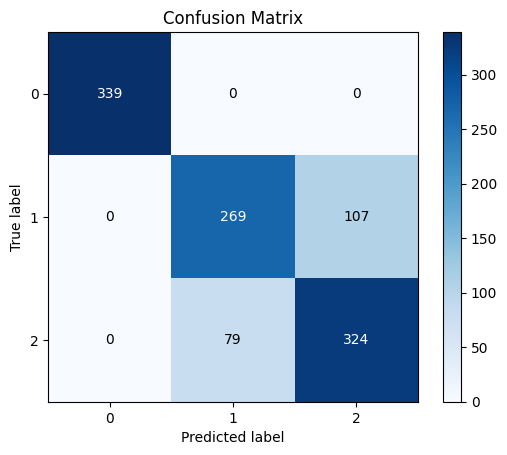

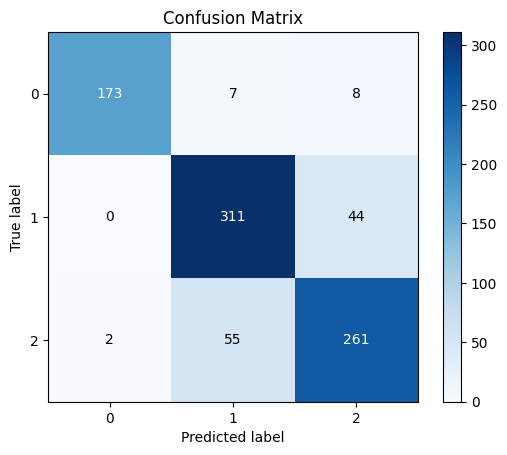

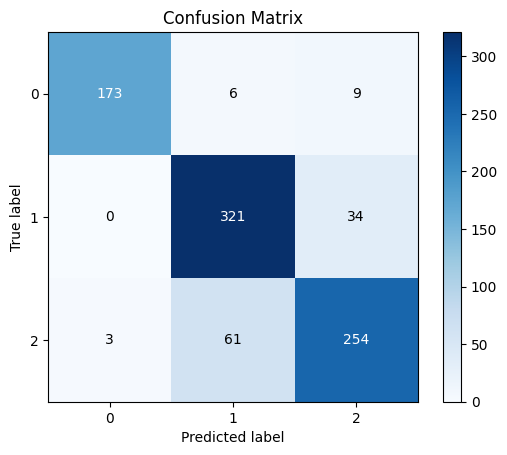

In [7]:
features = pd.DataFrame()

for i in range(len(nucleus_datasets)):
    dataset = nucleus_datasets[i].copy()
    dataset = macrophages_analysis.remove_correlated_features(dataset, 0.9)
    
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
    best_features = macrophages_analysis.get_best_features(nucleus_classifier, dataset.drop('CellType', axis=1), 25)
    features = pd.concat([features, best_features])
    
features.drop_duplicates(subset='Feature', inplace=True)
# features.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 40))   
resulting_features = features.Feature.to_list()
resulting_features.append('CellType')
print('Length of best_features', len(resulting_features))

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8202461389961391
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.828603093037054
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.861895215183106
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8646444684263672
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8572574178027264
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8602194645569929


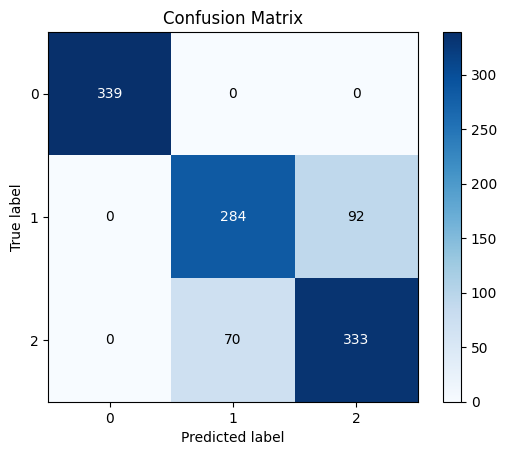

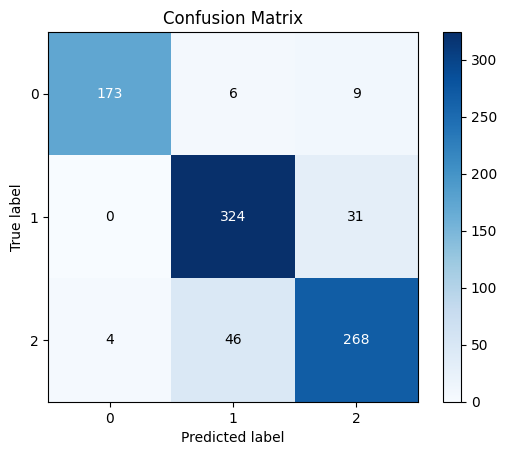

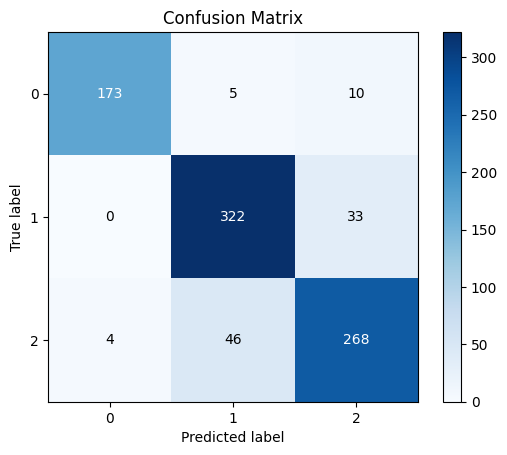

In [8]:
processed_nucleus_datasets = []

for i in range(len(nucleus_datasets)):
    
    dataset = nucleus_datasets[i].copy()
    dataset = dataset.loc[:, resulting_features]
    processed_nucleus_datasets.append(dataset)
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
processed_nucleus_datasets[0].to_csv(preprocessed_data_path + 'clean_10x_CD86_P4G4_nucleus_dataset.csv', index=False)
processed_nucleus_datasets[1].to_csv(preprocessed_data_path + 'clean_10x_CD86_Smooth_nucleus_dataset.csv', index=False)
processed_nucleus_datasets[2].to_csv(preprocessed_data_path + 'clean_10x_CD86_TCPS_nucleus_dataset.csv', index=False)

In [9]:
nucleus_features = processed_nucleus_datasets[0].columns.to_list()
no_shape_features = []

for i in nucleus_features:
    if not re.search("AreaShape", i):
        no_shape_features.append(i)

processed_nucleus_datasets[0].loc[:, no_shape_features].to_csv(preprocessed_data_path + 'clean_10x_CD86_P4G4_nucleus_dataset_no_shape_data.csv', index=False)
processed_nucleus_datasets[1].loc[:, no_shape_features].to_csv(preprocessed_data_path + 'clean_10x_CD86_Smooth_nucleus_dataset_no_shape_data.csv', index=False)
processed_nucleus_datasets[2].loc[:, no_shape_features].to_csv(preprocessed_data_path + 'clean_10x_CD86_TCPS_nucleus_dataset_no_shape_data.csv', index=False)

## Separate features lists

Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8237773487773488
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8248401213632549
Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8374766105319432
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8586503723678627
Amount of correlated features to drop: 114
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8409248863940121
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8568134229835092


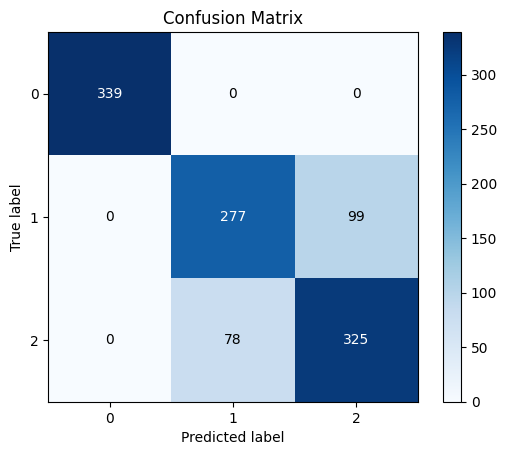

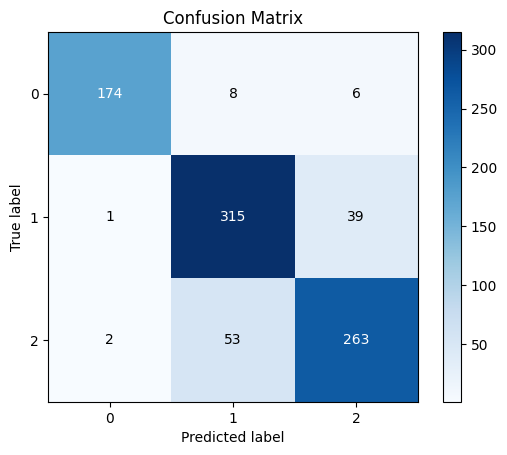

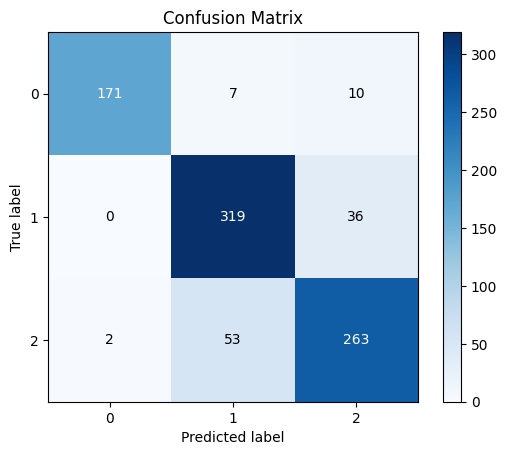

In [10]:
features = []

for i in range(len(nucleus_datasets)):
    dataset = nucleus_datasets[i].copy()
    dataset = macrophages_analysis.remove_correlated_features(dataset, 0.9)
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
    best_features = macrophages_analysis.get_best_features(nucleus_classifier, dataset.drop('CellType', axis=1), 30)
    
    best_features.drop_duplicates(subset='Feature', inplace=True)
    best_features = best_features.Feature.to_list()
    best_features.append('CellType')
    features.append(best_features)

Ampunt of features left:  30
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8202461389961391
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8344056519916222
Ampunt of features left:  30
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8537155840684308
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8573084940623634
Ampunt of features left:  30
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8386260358192995
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8609851166155222


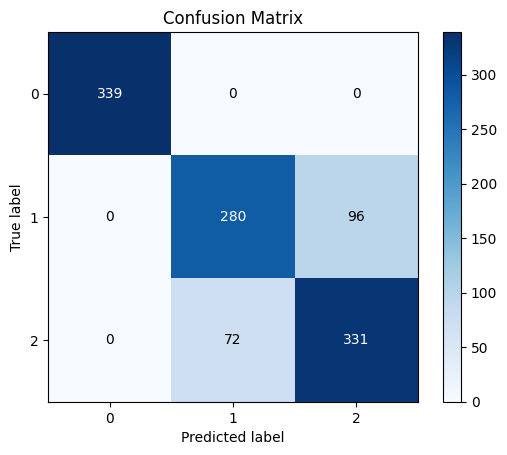

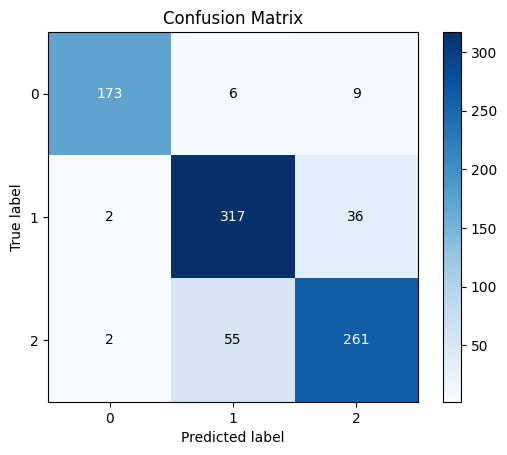

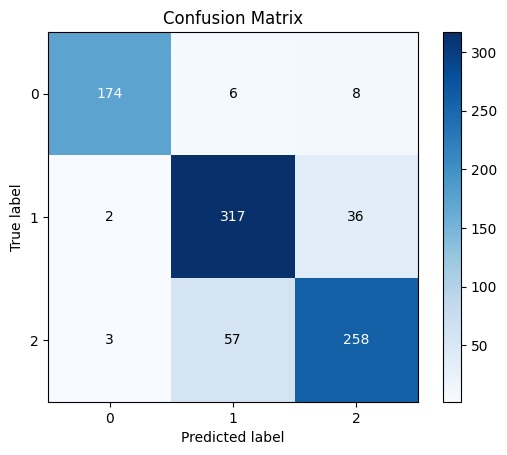

In [11]:
for i in range(len(nucleus_datasets)):
    dataset = nucleus_datasets[i].copy()
    dataset = dataset.loc[:, features[i]]
    print('Ampunt of features left: ', len(dataset.columns) - 1)
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)